# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2024/04/24<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_WIDTH  = 128
IMG_HEIGHT = 128

## Create a sampling layer

In [4]:
# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super().get_config()
        return config

## Build the encoder

In [5]:
latent_dim = 1024
def build_encoder():
    encoder_inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_inputs)
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(128, (5, 5), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

encoder = build_encoder()
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     51,264 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 33,555,456 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 1024)      │  1,049,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 1024)      │  1,049,600 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 1024)      │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,911,744 (136.99 MB)

 Trainable params: 35,911,744 (136.99 MB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [6]:
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(32 * 32 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    decoder_outputs = layers.Conv2DTranspose(3, (3,3), activation="relu", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │   134,348,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,441,923 (512.86 MB)

 Trainable params: 134,441,923 (512.86 MB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [8]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [9]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [10]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 2/2 [00:00<00:00,  7.82it/s]


In [11]:
def train_vae(images):
    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    history = vae.fit(images, epochs=150, batch_size=48)
    return history, vae

In [12]:
def save_vae(model_name, vae):
    encoder_path = model_folder + "/" + model_name + "_encoder.h5"
    decoder_path = model_folder + "/" + model_name + "_decoder.h5"
    vae.encoder.save(encoder_path)
    vae.decoder.save(decoder_path)
    vae.save(model_folder + "/" + model_name + ".h5")
    print(model_name, " Model saved")

In [13]:
import matplotlib.pyplot as plt
import json


def show_history(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['reconstruction_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [14]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [15]:
def test_vae(images, encoder, decoder):
    predictions = encoder.predict(images)
    predictions = decoder.predict(predictions[2])
    show_images(predictions)

Epoch 1/150


I0000 00:00:1716796177.556624   16663 service.cc:145] XLA service 0x73623c012e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716796177.556642   16663 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - kl_loss: 0.6348 - loss: 72120.1328 - reconstruction_loss: 72119.5000
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 299.6302 - loss: 56698.7734 - reconstruction_loss: 56399.1445
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 1994.5138 - loss: 43445.1680 - reconstruction_loss: 41450.6523
Epoch 4/150


I0000 00:00:1716796181.723652   16663 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 1612.6368 - loss: 32356.8516 - reconstruction_loss: 30744.2148
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - kl_loss: 655.9075 - loss: 24703.4258 - reconstruction_loss: 24047.5176
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - kl_loss: 410.8447 - loss: 20064.2500 - reconstruction_loss: 19653.4062
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - kl_loss: 538.3646 - loss: 17784.3613 - reconstruction_loss: 17245.9961
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 142.1883 - loss: 14832.5537 - reconstruction_loss: 14690.3652
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 69.8813 - loss: 13175.8506 - reconstruction_loss: 13105.9697
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - kl_loss: 95.2333 - loss: 11694.7627 - reconstruction_loss: 11599.5293
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 164.9853 - loss: 12213.0488 - reconstruction_loss: 12048.0635
Epoch 12/150
1/1 ━━━━━━━━━━

fyp_caries_vae1024v2  Model saved


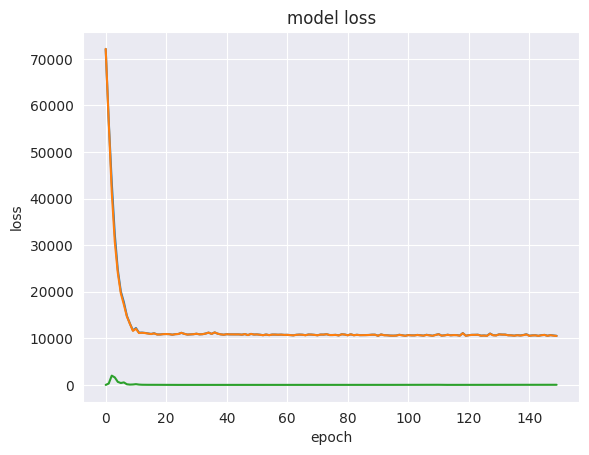

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


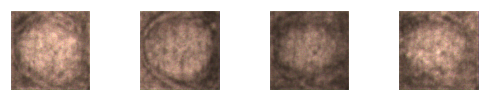

In [16]:
caries_history, caries_vae = train_vae(caries)
save_vae("fyp_caries_vae1024v2", caries_vae)
show_history(caries_history, "caries_vae1024v2")
test_vae(caries, caries_vae.encoder, caries_vae.decoder)

Epoch 1/150


I0000 00:00:1716796254.191781   19437 service.cc:145] XLA service 0x7489180014e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716796254.191802   19437 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - kl_loss: 1.4004 - loss: 56806.5742 - reconstruction_loss: 56805.1758
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 405.7505 - loss: 42948.5117 - reconstruction_loss: 42542.7617
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - kl_loss: 28869.4844 - loss: 59072.0312 - reconstruction_loss: 30202.5469
Epoch 4/150


I0000 00:00:1716796258.423067   19437 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - kl_loss: 1509.3871 - loss: 27202.5332 - reconstruction_loss: 25693.1465
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: 470.9382 - loss: 23325.3105 - reconstruction_loss: 22854.3730
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - kl_loss: 177.9949 - loss: 20407.2363 - reconstruction_loss: 20229.2422
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - kl_loss: 83.3408 - loss: 18163.1914 - reconstruction_loss: 18079.8496
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: 43.9031 - loss: 15980.6533 - reconstruction_loss: 15936.7500
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - kl_loss: 26.6279 - loss: 14252.9375 - reconstruction_loss: 14226.3096
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - kl_loss: 19.1040 - loss: 12665.7217 - reconstruction_loss: 12646.6172
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 16.9151 - loss: 11859.4785 - reconstruction_loss: 11842.5635
Epoch 12/150
1/1 ━━━━━━━━━━━━━

fyp_gingivitis_vae1024v2  Model saved


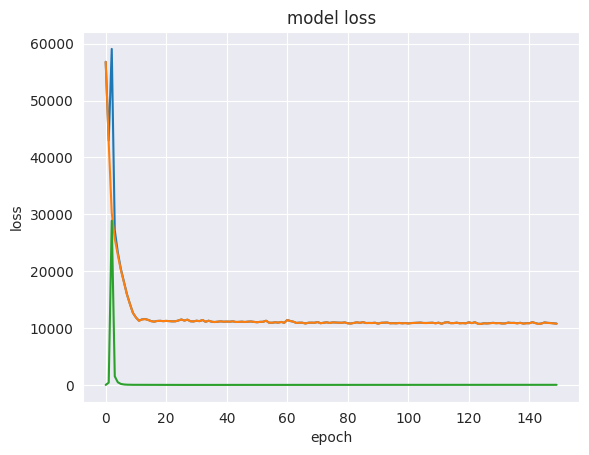

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


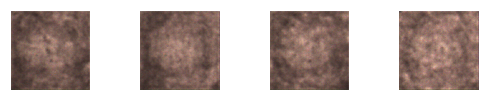

In [16]:
gingivitis_history, gingivitis_vae = train_vae(gingivitis)
save_vae("fyp_gingivitis_vae1024v2", gingivitis_vae)
show_history(gingivitis_history, "noncaries_vae1024v2")
test_vae(gingivitis, gingivitis_vae.encoder, gingivitis_vae.decoder)

Epoch 1/150


I0000 00:00:1716796341.830828   22218 service.cc:145] XLA service 0x7266fc0237e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716796341.830858   22218 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1716796343.090257   22285 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 8 bytes spill stores, 16 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - kl_loss: 1.7010 - loss: 83303.9375 - reconstruction_loss: 83302.2344
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 508.6149 - loss: 59158.7344 - reconstruction_loss: 58650.1211
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: 1124.5713 - loss: 40294.4141 - reconstruction_loss: 39169.8438
Epoch 4/150


I0000 00:00:1716796346.377337   22218 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - kl_loss: 13453.8125 - loss: 36462.8438 - reconstruction_loss: 23009.0293
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - kl_loss: 1514.0759 - loss: 19047.6953 - reconstruction_loss: 17533.6191
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - kl_loss: 545.8655 - loss: 15660.8770 - reconstruction_loss: 15115.0117
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - kl_loss: 251.2011 - loss: 14134.4385 - reconstruction_loss: 13883.2373
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - kl_loss: 150.3409 - loss: 13185.1445 - reconstruction_loss: 13034.8037
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - kl_loss: 114.8441 - loss: 12156.2764 - reconstruction_loss: 12041.4326
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - kl_loss: 105.1033 - loss: 11409.0596 - reconstruction_loss: 11303.9561
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - kl_loss: 87.2789 - loss: 11389.6963 - reconstruction_loss: 11302.4170
Epoch 12/150
1/1 ━━━━━━━

fyp_wsls_vae1024v2  Model saved


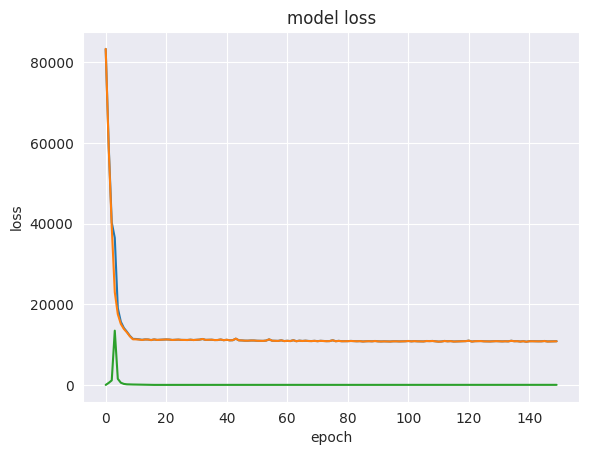

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


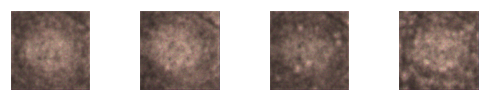

In [16]:
wsls_history, wsls_vae = train_vae(wsl)
save_vae("fyp_wsls_vae1024v2", wsls_vae)
show_history(wsls_history, "wsls_vae1024v2")
test_vae(wsl, wsls_vae.encoder, wsls_vae.decoder)

In [ ]:
predictions = caries_vae.encoder.predict(caries)
len(predictions)